<a href="https://colab.research.google.com/github/MaksymilianSzymczak/ML24/blob/main/domowe9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment - *Do Androids Dream of Electric Sheep?***

-------------------------------------  

"Do Androids Dream of Electric Sheep?" – the famous title of Philip K. Dick’s novel – raises a fascinating question: if artificial intelligence could dream, what would it see?  

In this assignment, we explore a phenomenon known as **neural network dreams**, where instead of optimizing a neural network's weights, we **optimize the input itself** to achieve a desired classification outcome. Given a fully trained MNIST classification network, your goal is to manipulate its inputs so that it confidently predicts each digit from 0 to 9, starting from pure noise.  

## **Tasks Description**  

During this class we designed and trained a **MNIST classification neural network**, which takes a **batch of grayscale images** of size **$28 \times 28$** as input and outputs a probability distribution over the 10 digit classes (0–9). However, instead of using real MNIST images, you will **treat the input batch itself as a set of trainable parameters** and optimize it so that the network classifies each image as a specific digit.  

1. Your first task is to generate **a batch of 10 images**, where each image is
   classified as one of the digits **0, 1, 2, ..., 9**, starting from an initial batch of ten random Gaussian noise images.  

   Discuss the following question: do the generated images resemble real MNIST digits? Why or why not?  

2. Discuss, how you would approach a second task of
   generating an image that   
   bares similarity to two or more digits simultaneously. **Implement your idea to see the results.**

3. Third task: repeat the previous tasks with an additional L2 penalty on noise within the images. Experiment with adding `lambda_l2 * dreamed_input_batch.pow(2).mean()` loss term, with `lambda_l2` being the penalty cooefficient within an exponential progression, say from 0.001 to 10.0. Are the new digits recognized correctly? How does the penalty impact the digit quality? Explain.

### **Optimization Process for Task 1**  

1. Start with a **batch of 10 random Gaussian noise images** as the initial input and $(0, 1, 2, \ldots, 9)$ as the expected output batch of target digits.  
2. Define the objective: maximize the neural network's confidence for the corresponding target digit for each image in the batch.  
3. Use **gradient descent** to modify the pixels in each image, making the network classify each one as the assigned digit.  
4. Repeat until the network assigns suffieciently high confidence to each image’s target class.  

### **Implementation Details**  

- The neural network weights **must remain frozen** during optimization. You are modifying only the input images.  
- The loss function should be the **cross-entropy loss** between the predicted probabilities and the desired class labels (plus an optional weighted L2 penalty regularizing the images in task 3).


## **Points to Note**  

1. **Visualize** the optimization process: Save images of the generated inputs at different steps and plot the classification confidence evolution over iterations.  
3. **Document your findings** and explain the behavior you observe.  

## **Task & Deliverables**  

- A **Colab notebook** containing solutions for both tasks:
  - The full implementation.
  - Visualizations of the generated batch of images.
  - A written explanation of your observations.
- **Bonus:** If you create an **animation** showing the evolution of the input images during optimization, it will be considered a strong enhancement to your submission.
  - You can generate an animation programmatically (e.g., using Matplotlib or OpenCV).
  - Or, save image frames and use external tools to create a video.
  - Provide a **link** to any video files in the README.
- Upload your notebook and results to your **GitHub repository** for the course.
- In the **README**, include a **link** to the notebook.
- In the notebook, include **“Open in Colab”** badge so it can be launched directly.




---
**Uwaga**

Chciałem uprzedzić, że jeśli wyniki (albo sam proces) byłyby za mało szczegółowe, to chętnię spróbuję poprawić np. dla większej ilośći epochsów albo większej ilości batchów, bo jak narazie próbowałem cokolwiek dla poprawy to collab myślał pół dnia nad trenowaniem sieci.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms

# Przygotowanie danych
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=2048, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

# Definicja modelu
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(28*28, 1024)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(1024, 2048)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(2048, 256)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.05)

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.linear3(x)
        x = self.relu3(x)
        x = self.linear4(x)
        x = self.dropout(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = MLP().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Trening
net.train()
for epoch in range(8):
    for batch, (batch_inputs, batch_labels) in enumerate(trainloader):
        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)
        optimizer.zero_grad()
        batch_outputs = net(batch_inputs)
        loss = criterion(batch_outputs, batch_labels)
        loss.backward()
        optimizer.step()
        if batch % 10 == 0:
            print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())

# Testowanie
net.eval()
good = 0
wrong = 0
with torch.no_grad():
    for batch_inputs, batch_labels in testloader:
        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)
        outputs = net(batch_inputs)
        prediction = torch.argmax(outputs)
        if prediction.item() == batch_labels.item():
            good += 1
        else:
            wrong += 1
print("accuracy = ", good/(good+wrong))


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.39MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 289kB/s]


epoch: 0 batch: 0 current batch loss: 2.3099846839904785
epoch: 0 batch: 10 current batch loss: 0.6229434013366699
epoch: 0 batch: 20 current batch loss: 0.40805840492248535
epoch: 1 batch: 0 current batch loss: 0.27326449751853943
epoch: 1 batch: 10 current batch loss: 0.202457994222641
epoch: 1 batch: 20 current batch loss: 0.1696392446756363
epoch: 2 batch: 0 current batch loss: 0.12674163281917572
epoch: 2 batch: 10 current batch loss: 0.14055247604846954
epoch: 2 batch: 20 current batch loss: 0.12898167967796326
epoch: 3 batch: 0 current batch loss: 0.09206127375364304
epoch: 3 batch: 10 current batch loss: 0.09479443728923798
epoch: 3 batch: 20 current batch loss: 0.0805826336145401
epoch: 4 batch: 0 current batch loss: 0.0866909995675087
epoch: 4 batch: 10 current batch loss: 0.07516736537218094
epoch: 4 batch: 20 current batch loss: 0.07218057662248611
epoch: 5 batch: 0 current batch loss: 0.042065832763910294
epoch: 5 batch: 10 current batch loss: 0.073550745844841
epoch: 5 ba

Epoch 0, loss: 6.096895694732666
Epoch 50, loss: 3.5046919037995394e-06
Epoch 100, loss: 2.7298558507027337e-06
Epoch 150, loss: 2.241109768874594e-06
Epoch 200, loss: 1.8596477957544266e-06
Epoch 250, loss: 1.5735504348413087e-06
Epoch 300, loss: 1.3351352663448779e-06
Epoch 350, loss: 1.1563236057554604e-06
Epoch 400, loss: 1.0251948197037564e-06
Epoch 450, loss: 9.059866101779335e-07
Epoch 500, loss: 8.106200084512238e-07
Epoch 550, loss: 7.390949576802086e-07
Epoch 600, loss: 6.675699069091934e-07
Epoch 650, loss: 6.079656031943159e-07
Epoch 700, loss: 5.483612994794385e-07
Epoch 750, loss: 5.125986604070931e-07
Epoch 800, loss: 4.7683607817816664e-07
Epoch 850, loss: 4.4107346752753074e-07
Epoch 900, loss: 4.172316891981609e-07
Epoch 950, loss: 3.933899392905005e-07
Epoch 1000, loss: 3.6954816096113063e-07
Epoch 1050, loss: 3.576272717964457e-07
Epoch 1100, loss: 3.2186460430239094e-07
Epoch 1150, loss: 2.980228259730211e-07
Epoch 1200, loss: 2.980228259730211e-07
Epoch 1250, loss

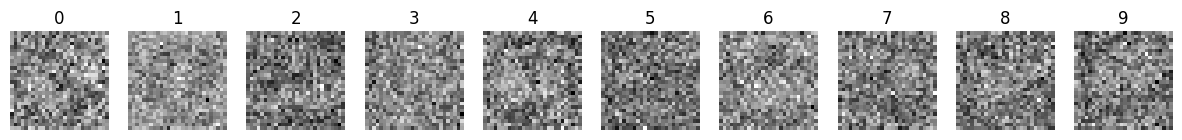

In [3]:
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.eval()

# Inicjalizacja szumu
dream_imgs = torch.randn(10, 1, 28, 28, device=device, requires_grad=True)
target_labels = torch.arange(10, device=device)

optimizer = torch.optim.Adam([dream_imgs], lr=0.1)

for epoch in range(2000):
    optimizer.zero_grad()
    outputs = net(dream_imgs)
    loss = torch.nn.functional.cross_entropy(outputs, target_labels)
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, loss: {loss.item()}")

# Wizualizacja wygenerowanych obrazów
dream_imgs_vis = dream_imgs.detach().cpu().squeeze().numpy()
fig, axes = plt.subplots(1, 10, figsize=(15,2))
for i, ax in enumerate(axes):
    ax.imshow(dream_imgs_vis[i], cmap='gray')
    ax.set_title(str(i))
    ax.axis('off')
plt.show()


---
**Odpowiedź na task 1**

Wygenerowane przez sieć obrazy nie przypominają prawdziwych cyfr z MNIST, nawet jeśli sieć klasyfikuje je z niemal stuprocentową pewnością (widzimy, że dla coraz wyższych "epok" loss robi się coraz mniejszy, a co za tym idzie "confidence" - prawdopodobieństwo według algorytmu, że obraz to konkretna cyfra zbliża się do wartości 1). Dzieje się tak no bo sieć neuronowa nie musi tworzyć obrazów podobnych do tych widzianych przez człowieka – wystarczy, że na obrazie pojawią się takie wzorce pikseli, które sieć uzna za charakterystyczne dla danej cyfry, nawet jeśli są one dla nas zupełnie nieczytelne. W efekcie optymalizacja prowadzi do powstawania szumowych, abstrakcyjnych kształtów, które dla sieci są wystarczające, by „być pewną” rozpoznania klasy, ale dla człowieka wyglądają raczej jak przypadkowe plamy niż cyfry. Dodatkowo, ponieważ nie ograniczamy szumu ani nie narzucamy żadnych reguł na kształt obrazu, sieć „śni” obrazy matematycznie poprawne z jej punktu widzenia, lecz całkowicie obce naszemu postrzeganiu.

Step 0
  Class 3: 0.0044
  Class 8: 0.0021
  Mean Target Prob: 0.0033

Step 100
  Class 3: 0.5001
  Class 8: 0.4994
  Mean Target Prob: 0.4997

Step 200
  Class 3: 0.4999
  Class 8: 0.4999
  Mean Target Prob: 0.4999

Step 300
  Class 3: 0.5000
  Class 8: 0.4999
  Mean Target Prob: 0.4999

Step 400
  Class 3: 0.5065
  Class 8: 0.4933
  Mean Target Prob: 0.4999

Step 500
  Class 3: 0.5558
  Class 8: 0.4441
  Mean Target Prob: 0.4999

Step 600
  Class 3: 0.4991
  Class 8: 0.5008
  Mean Target Prob: 0.4999

Step 700
  Class 3: 0.5101
  Class 8: 0.4898
  Mean Target Prob: 0.5000

Step 800
  Class 3: 0.5314
  Class 8: 0.4686
  Mean Target Prob: 0.5000

Step 900
  Class 3: 0.4675
  Class 8: 0.5324
  Mean Target Prob: 0.5000

Step 1000
  Class 3: 0.4731
  Class 8: 0.5269
  Mean Target Prob: 0.5000

Step 1100
  Class 3: 0.5162
  Class 8: 0.4837
  Mean Target Prob: 0.5000

Step 1200
  Class 3: 0.4759
  Class 8: 0.5241
  Mean Target Prob: 0.5000

Step 1300
  Class 3: 0.4753
  Class 8: 0.5247
  Me

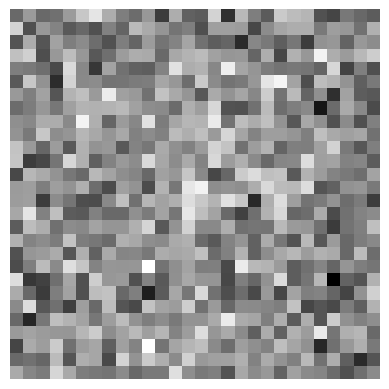

In [4]:
def generate_hybrid_dream(model, target_classes, iterations=2000, lr=0.1):
    device = next(model.parameters()).device
    model.eval()

    input_img = torch.randn(1, 1, 28, 28, device=device, requires_grad=True)
    targets = torch.tensor(target_classes, device=device)

    optimizer = torch.optim.Adam([input_img], lr=lr)

    for step in range(iterations):
        optimizer.zero_grad()
        outputs = model(input_img)
        probs = torch.softmax(outputs, dim=1).squeeze()

        losses = [torch.nn.functional.cross_entropy(outputs, t.unsqueeze(0))
                 for t in targets]
        loss = torch.mean(torch.stack(losses))
        loss.backward()
        optimizer.step()

        if step % 100 == 0 or step == iterations-1:
            target_probs = [probs[t].item() for t in targets]
            mean_prob = sum(target_probs)/len(target_probs)

            print(f"Step {step}")
            for t, p in zip(targets, target_probs):
                print(f"  Class {t.item()}: {p:.4f}")
            print(f"  Mean Target Prob: {mean_prob:.4f}\n")

    return input_img.detach().cpu()

# Uruchomienie dla klas 3 i 8
hybrid_img = generate_hybrid_dream(net, [3, 8], iterations=2000)

# Wizualizacja
plt.imshow(hybrid_img[0][0], cmap='gray')
plt.axis('off')
plt.show()


---
**Odpowiedź task 2:**

Gdy próbujemy stworzyć obraz będący połączeniem dwóch cyfr (np. 3 i 8), okazuje się, że sieć neuronowa nadal generuje abstrakcyjne wzorce zamiast czytelnych kształtów. Choć po 2000 iteracji prawdopodobieństwa dla obu klas stabilizują się na podobnym poziomie (~0.5), sam obraz nie przypomina logicznej mieszanki cyfr – wygląda raczej jak zlepek przypadkowych kresek i plam. Można dopatrzeć się zarysu zarówno 3 jak i 8 na obrazku.

Dlaczego tak się dzieje? Sieć nie szuka kompromisu wizualnego, tylko matematycznego. Każdy piksel jest optymalizowany tak, by jednocześnie aktywować neurony dla obu klas. W praktyce oznacza to, że sieć "oszukuje", znajdując wzorce pikseli, które przypadkiem pasują do obu cyfr – na przykład fragment pętli aktywujący ósemkę i ukośna kreska kojarząca się z trójką. To tak, jakby próbować narysować jednocześnie kotka i samochód, używając tych samych linii – efekt zawsze będzie dziwaczny.

Co ważne, te hybrydowe obrazy potwierdzają wnioski z Task 1: sieć nie rozumie cyfr jak człowiek. Dla niej liczą się statystyczne korelacje pikseli, a nie geometryczne kształty. Nawet gdy zmuszamy ją do "myślenia o dwóch klasach naraz", wciąż generuje szumowe wzorce, które dla nas są nieczytelne, ale dla jej matematycznego "umysłu" – idealnie spełniają zadanie.


In [5]:
def generate_dreams_L2_verbose(model, lambda_l2=0.01, iterations=2000, print_step=500):
    device = next(model.parameters()).device
    model.eval()

    input_batch = torch.randn(10, 1, 28, 28, device=device, requires_grad=True)
    targets = torch.arange(10, device=device)

    optimizer = torch.optim.Adam([input_batch], lr=0.1)

    for step in range(iterations):
        optimizer.zero_grad()
        outputs = model(input_batch)
        probs = torch.softmax(outputs, dim=1)

        ce_loss = torch.nn.functional.cross_entropy(outputs, targets)
        l2_loss = lambda_l2 * torch.mean(input_batch**2)
        total_loss = ce_loss + l2_loss

        total_loss.backward()
        optimizer.step()

        if step % print_step == 0 or step == iterations-1:
            target_probs = [probs[i, i].item() for i in range(10)]
            print(f"λ={lambda_l2:.3f}, Step {step}, Loss: {total_loss.item():.4f}, "
                  f"P(class): {[round(p, 3) for p in target_probs]}")

    return input_batch.detach().cpu()

# Przetestuj dla różnych wartości lambda
lambdas = [0.001, 0.01, 0.1, 1.0, 10.0]
for lam in lambdas:
    _ = generate_dreams_L2_verbose(net, lambda_l2=lam, iterations=2000)
    print("\n" + "="*50 + "\n")


λ=0.001, Step 0, Loss: 5.9358, P(class): [0.003, 0.32, 0.046, 0.002, 0.0, 0.004, 0.004, 0.074, 0.0, 0.002]
λ=0.001, Step 500, Loss: 0.0013, P(class): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
λ=0.001, Step 1000, Loss: 0.0011, P(class): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
λ=0.001, Step 1500, Loss: 0.0009, P(class): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
λ=0.001, Step 1999, Loss: 0.0007, P(class): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


λ=0.010, Step 0, Loss: 6.2440, P(class): [0.005, 0.001, 0.004, 0.009, 0.003, 0.004, 0.003, 0.005, 0.0, 0.0]
λ=0.010, Step 500, Loss: 0.0081, P(class): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
λ=0.010, Step 1000, Loss: 0.0036, P(class): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
λ=0.010, Step 1500, Loss: 0.0016, P(class): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
λ=0.010, Step 1999, Loss: 0.0008, P(class): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


λ=0.100, Step 0, Loss: 

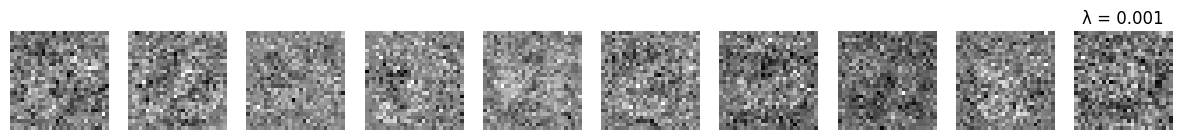

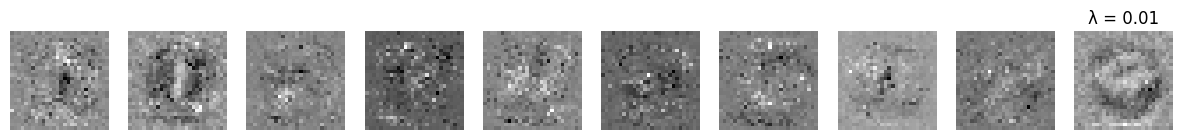

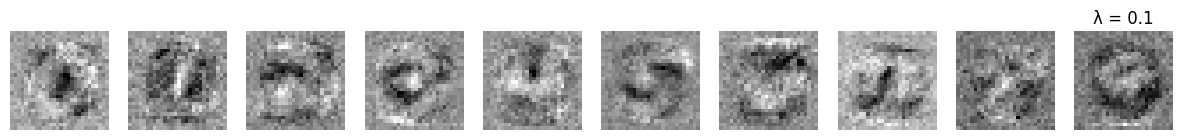

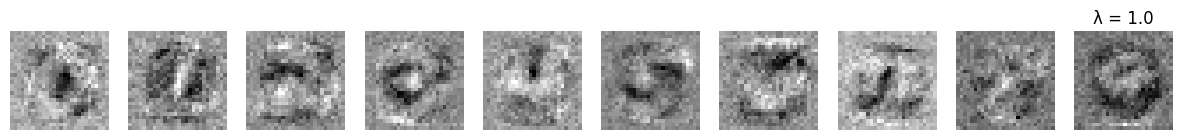

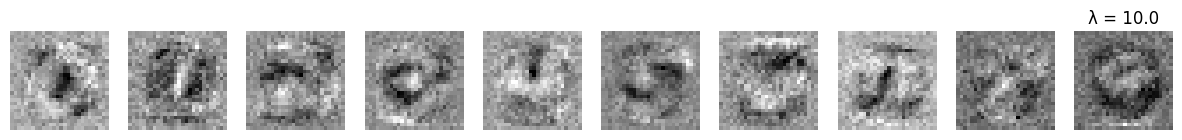

In [6]:
def generate_dreams_L2(model, lambda_l2=0.01, iterations=2000):
    device = next(model.parameters()).device
    model.eval()

    input_batch = torch.randn(10, 1, 28, 28, device=device, requires_grad=True)
    targets = torch.arange(10, device=device)

    optimizer = torch.optim.Adam([input_batch], lr=0.1)

    for _ in range(iterations):
        optimizer.zero_grad()
        outputs = model(input_batch)
        ce_loss = torch.nn.functional.cross_entropy(outputs, targets)
        l2_loss = lambda_l2 * torch.mean(input_batch**2)
        total_loss = ce_loss + l2_loss

        total_loss.backward()
        optimizer.step()

    return input_batch.detach().cpu()


lambdas = [0.001, 0.01, 0.1, 1.0, 10.0]
for lam in lambdas:
    dreams = generate_dreams_L2(net, lambda_l2=lam)

    # Wizualizacja
    plt.figure(figsize=(15, 2))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(dreams[i][0], cmap='gray')
        plt.axis('off')
    plt.title(f"λ = {lam}")
    plt.show()


---


**Odpowiedź na Task 3:**  

Dodanie kary L2 podczas optymalizacji sprawia, że obrazy stają się coraz bardziej wygładzone i mniej szumowe niż w tasku 1, ale sieć nadal rozpoznaje je z bardzo wysoką pewnością. Nawet przy bardzo dużej wartości λ, kiedy obrazki przypominają niemal jednolite szarości, sieć wciąż przypisuje im prawdopodobieństwa rozpoznania na poziomie 97–98%. Oznacza to, że regularyzacja L2 ogranicza ekstremalne wartości pikseli i wygładza obrazy, ale nie przeszkadza sieci w pewnej klasyfikacji. W praktyce nawet bardzo proste, nieczytelne dla człowieka wzorce wystarczają, by sieć była niemal całkowicie przekonana, że widzi właściwą cyfrę.

In [7]:
#Jakaś animacja

!apt install ffmpeg

import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

def generate_dreams_animation(model, iterations=2000, lr=0.1, save_path='dream_evolution.mp4'):
    device = next(model.parameters()).device
    model.eval()

    # Inicjalizacja szumu
    input_batch = torch.randn(10, 1, 28, 28, device=device, requires_grad=True)
    targets = torch.arange(10, device=device)

    # Konfiguracja animacji
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    plt.subplots_adjust(wspace=0.1, hspace=0.3)
    ims = []

    optimizer = torch.optim.Adam([input_batch], lr=lr)

    # Funkcja denormalizacji
    def denormalize(img):
        return (img * 0.3081) + 0.1307  # MNIST: mean=0.1307, std=0.3081

    for step in range(iterations):
        optimizer.zero_grad()
        outputs = model(input_batch)
        loss = torch.nn.functional.cross_entropy(outputs, targets)
        loss.backward()
        optimizer.step()

        if step % 50 == 0 or step == iterations-1:
            with torch.no_grad():
                current_imgs = denormalize(input_batch.detach().cpu().numpy())

            frame = []
            for i, ax in enumerate(axes.flatten()):
                ax_img = ax.imshow(current_imgs[i][0], cmap='gray', animated=True, vmin=0, vmax=1)
                ax.set_title(f'Step {step}\nClass {i}', fontsize=8)
                ax.axis('off')
                frame.append(ax_img)
            ims.append(frame)

    # Kompilacja animacji
    ani = FuncAnimation(fig, lambda x: ims[x], frames=len(ims), interval=50, blit=True)
    ani.save(save_path, writer='ffmpeg', fps=15, dpi=100)
    plt.close()
    return input_batch.detach().cpu()

dreams = generate_dreams_animation(net, iterations=2000)


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


Ten bonusowy kod pozwala zobaczyć, jak sieć neuronowa "śni" (dreamuje?) – czyli jak z losowego szumu krok po kroku powstają obrazy, które sieć rozpoznaje jako cyfry. Animacja pokazuje cały proces: na początku widzimy kompletny chaos, ale z każdą kolejną iteracją piksele zaczynają się układać w coraz bardziej charakterystyczne dla sieci wzory. Oczywiście nie ma efektu wow bo jak chciałem robić coś dokłądniej (więcej epok chociażby) to średnio chciał collab współpracować (tak jak pisałem na początku, stąd może mała dokładność miejscami).

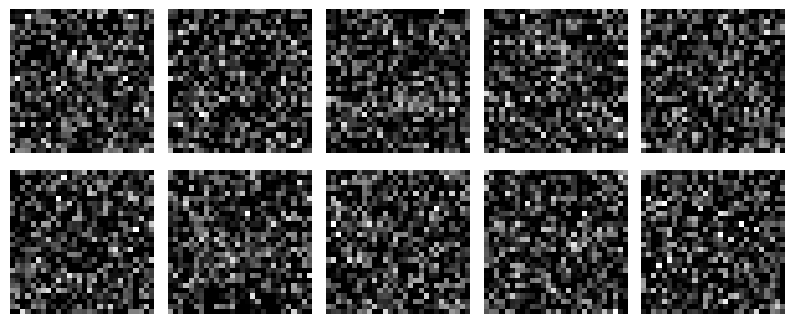

In [8]:
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.eval()

# Inicjalizacja szumu
input_batch = torch.randn(10, 1, 28, 28, device=device, requires_grad=True)
targets = torch.arange(10, device=device)

optimizer = torch.optim.Adam([input_batch], lr=0.1)

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
ims = []
for ax in axes.flatten():
    im = ax.imshow(np.zeros((28, 28)), cmap='gray', vmin=0, vmax=1, animated=True)
    ax.axis('off')
    ims.append(im)


def denormalize(img):
    return np.clip(img * 0.3081 + 0.1307, 0, 1)

def update(frame):
    optimizer.zero_grad()
    outputs = net(input_batch)
    loss = torch.nn.functional.cross_entropy(outputs, targets)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        for i, im in enumerate(ims):
            img = input_batch[i, 0].detach().cpu().numpy()
            im.set_array(denormalize(img))
    return ims

ani = FuncAnimation(fig, update, frames=100, interval=100, blit=True)
plt.show()

ani.save('dream_evolution.mp4', writer='ffmpeg', fps=10, dpi=100)